In [37]:
import csv
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [38]:
#extract the 1st 250 molecules form all dataset with lowest energy values
# Path to your CSV file
filepath = r'Data\Dataset250ksamples.csv'
# List to store lines from the CSV file
data_array = []
# Open and read the CSV file
with open(filepath, mode='r') as file:
    csvFile = csv.reader(file)
    # Append each line in the CSV file to the data_array list
    for line in csvFile:
        data_array.append(line)

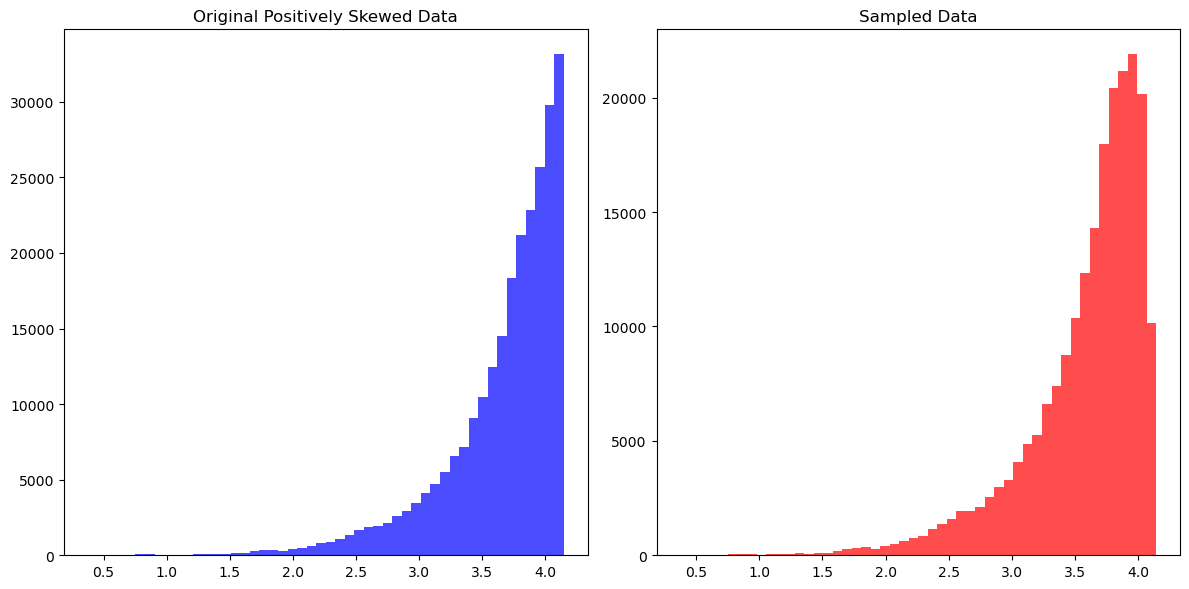

In [39]:
# Extract number of samples from above dataset to be the data normaly distributed dataset.
# Extract the 'Label' values, skipping the header
data = [float(item[1]) for item in data_array[1:]]
data_np = np.array(data)  # Convert the list to a NumPy array

# Generate a weighting scheme where lower values have higher weight to counteract positive skew
weights = data_np.max() - data_np

# Normalize the weights so they sum up to 1
weights /= weights.sum()

# Sample indices from the original data using the weights
sampled_indices = np.random.choice(np.arange(len(data_np)), size=min(210000, len(data_np)), p=weights, replace=False)

# Retrieve the sampled SMILES strings and 'Label' values using the sampled indices
sampled_data_array = [data_array[i+1] for i in sampled_indices]  # +1 to account for the header
sampled_labels = [data[i] for i in sampled_indices]

# Plot the histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_np, bins=50, color='blue', alpha=0.7)
plt.title('Original Positively Skewed Data')

plt.subplot(1, 2, 2)
plt.hist(sampled_labels, bins=50, color='red', alpha=0.7)
plt.title('Sampled Data')

plt.tight_layout()
plt.show()

# The variable 'sampled_data_array' now contains the sampled SMILES with their corresponding 'Label' values
#print(sampled_data_array)

In [40]:
# count the num of smiles charactor  Skip the header and iterate through the rest
def countMaxSmileSize(dataArray):
    maxCharCount = 0
    for row in dataArray:
        charCount = len(row[0])
        if maxCharCount < charCount:
            maxCharCount = charCount  
    return maxCharCount

In [41]:
def numOfmolwith(dataArray,char):
    count = 0
    for row in dataArray:
        if char in row[0]:
            count = count + 1
    return count

In [42]:
print(countMaxSmileSize(sampled_data_array[1:]))

# Limit the smlie size to 60 and exclude the molecules with heavy atoms (.,Ge,Ti,Zn,Se).
data_array_1 = []
maxAtoms = 50
count = 0

elements = ['.', 'Ge', 'ge', 'Ti','ti', 'Zn', 'zn', 'Se', 'se', '6',  'b', 'p' , 'si', '6']

for row in sampled_data_array[1:]:
    charCount = len(row[0])
    if charCount <= maxAtoms:
        if any(elements in row[0] for elements in elements):
            count += 1
        else:
            data_array_1.append(row)
            
print(countMaxSmileSize(data_array_1[1:]))
print("Number of molecules rejected ",count)

110
50
Number of molecules rejected  530


In [43]:
#convert smailes to canonical form
data_array_can = []
maxAtoms = 50
for row in data_array_1[1:]:
    mol = Chem.MolFromSmiles(row[0])
    row[0] = Chem.MolToSmiles(mol, canonical=True)
    data_array_can.append(row) 

In [44]:
# Specify your desired file name
filename = "Data/CanonicalSmiles.csv"

# Open the file for writing
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write each row to the CSV
    for row in data_array_can:
        writer.writerow(row)

print(f"Data saved to {filename}")

# List to store lines from the CSV file
data_array = []
# Open and read the CSV file
with open(filename, mode='r') as file:
    csvFile = csv.reader(file)
    
    # Append each line in the CSV file to the data_array list,
    for line in csvFile:
        data_array.append(line)
        
print('sample size ' , len(data_array))

Data saved to Data/CanonicalSmiles.csv
sample size  208742


In [45]:
print(numOfmolwith(data_array[1:],'Po'))

0


In [46]:
characters = set()

datasmiles = [(item[0]) for item in data_array[1:]]

for item in datasmiles:
    for char in item:
        characters.add(char)
        
sorted_characters = sorted(characters)
print(sorted_characters)

['#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '=', '@', 'A', 'B', 'C', 'F', 'H', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'i', 'l', 'n', 'o', 'p', 'r', 's']


In [47]:
newTokenizer = ['0', 'C', 'c', '(',  ')',  '1',  'O',  '=', 'N',  '2',  '[',  ']',  'n',  '3',  'H',  'S',  '-',  '#',  '+',  's',  'o', 'P',  'F',  '4',  'p'  , '/', '\\', '@', 'As', 'B', 'Br', 'b', 'Si', 'Cl', '5']
# Convert the tokenizer list to a dictionary with the index as the key
tokenizer_dict = {idx: token for idx, token in enumerate(newTokenizer)}
# Save to pickle file
with open('newTokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer_dict, file)
print("Tokenizer saved to newTokenizer.pkl")

Tokenizer saved to newTokenizer.pkl


In [48]:
#load the tokenizer
with open('newTokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
#add a token for padding
tokenizer[0] = ' '

In [49]:
# # Load the tokenizer
# with open(r'D:\Studies\PHD\Research\Study\Study 4\RRCGAN_Molecules_Ehl-main\data\trainingsets\train_regular_pubqc130K\tokenizer.pickle', 'rb') as f:
#     tokenizer = pickle.load(f)
# newTokenizer[0] = ' '

# Inverse tokenizer for mapping symbols to integers
inv_tokenizer = {v: k for k, v in tokenizer.items()}

# Define max_length as 40
max_length = 50

def tokenize_smiles(smiles, inv_tokenizer):
    i = 0
    tokens = []
    while i < len(smiles):
        # Try to match 2-character tokens first
        if i < len(smiles) - 1 and smiles[i:i+2] in inv_tokenizer:
            tokens.append(smiles[i:i+2])
            i += 2
        # If not matched, then match 1-character tokens
        elif smiles[i] in inv_tokenizer:
            tokens.append(smiles[i])
            i += 1
        else:
            tokens.append(' ')  # Default to space if not recognized
            i += 1
    return tokens

def smiles_to_one_hot(smiles, tokenizer, inv_tokenizer, max_length):
    # Tokenize the SMILES
    tokenized_smiles = tokenize_smiles(smiles, inv_tokenizer)
    
    # Truncate or pad the tokenized list to match max_length
    if len(tokenized_smiles) > max_length:
        tokenized_smiles = tokenized_smiles[:max_length]
    else:
        tokenized_smiles += [' '] * (max_length - len(tokenized_smiles))
    
    # Convert the tokenized SMILES to integer representation
    int_representation = [inv_tokenizer.get(token, 0) for token in tokenized_smiles]
    
    # One-hot encoding
    one_hot = np.zeros((max_length, len(tokenizer)))
    for i, integer in enumerate(int_representation):
        one_hot[i, integer] = 1
    
    return one_hot





# def smiles_to_one_hot(smiles, tokenizer, inv_tokenizer, max_length):
#     # Tokenize the SMILES
#     tokenized_smiles = tokenize_smiles(smiles, inv_tokenizer)
    
#     # Pad the tokenized list
#     tokenized_smiles += [' '] * (max_length - len(tokenized_smiles))
    
#     # Convert the tokenized SMILES to integer representation
#     int_representation = [inv_tokenizer.get(token, 0) for token in tokenized_smiles]
    
#     # One-hot encoding
#     one_hot = np.zeros((max_length, len(tokenizer)))
#     for i, integer in enumerate(int_representation):
#         one_hot[i, integer] = 1
    
#     return one_hot

# Extract SMILES strings and HOMO-LUMO gaps
smiles_strings = [item[0] for item in data_array]
values = [item[1] for item in data_array]

# Convert the SMILES strings to one-hot encoding
#one_hot_encoded_data = [smiles_to_one_hot(smiles, tokenizer, inv_tokenizer) for smiles in smiles_strings]

# Convert the SMILES strings to one-hot encoding
one_hot_encoded_data = [smiles_to_one_hot(smiles, tokenizer, inv_tokenizer, max_length) for smiles in smiles_strings]

# Create the data structure to be saved
alldata = (np.array(one_hot_encoded_data), np.array(smiles_strings), np.array(values))

# Save as pickle file
with open('CanonicalSmiles1.pickle', 'wb') as f:
    pickle.dump(alldata, f)

In [50]:
with open('CanonicalSmiles1.pickle', 'rb') as f:
        X_smiles_train1, SMILES_train1, y_train1 = pickle.load(f)
        
print(X_smiles_train1.shape)

(208742, 50, 35)


3.806872768495


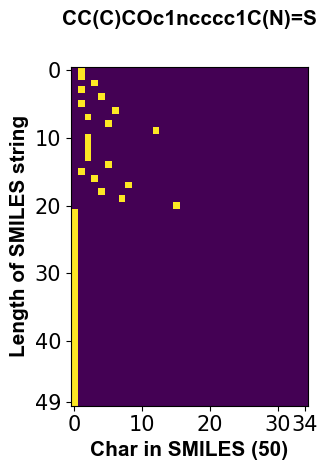

In [53]:
Molecule = 66
plt.imshow(X_smiles_train1[Molecule-1].reshape([50, 35]), )
plt.title(SMILES_train1[Molecule-1], fontfamily='Arial', fontsize=15, fontweight='bold', pad=30)
plt.xlabel('Char in SMILES (50)', fontfamily='Arial', fontsize=15, fontweight='bold'), 
plt.ylabel('Length of SMILES string', fontfamily='Arial', fontsize=15, fontweight='bold')
plt.xticks((0, 10, 20, 30, 34), size=15)
plt.yticks((0, 10, 20, 30, 40, 49), size=15)
plt.tight_layout()
plt.tight_layout()
plt.savefig('sample_smiles_{}', dpi=500)
print (y_train1[Molecule-1])